In [19]:
import pint
import xarray as xr
from dask.distributed import Client
from seapopym.configuration.no_transport.parameter import ForcingParameters
from seapopym.configuration.parameters.parameter_forcing import ForcingUnit
from seapopym.standard.units import StandardUnitsLabels

from seapopym_optimization import (
    FunctionalGroupOptimizeNoTransport,
    GeneticAlgorithm,
    GeneticAlgorithmParameters,
    NoTransportCostFunction,
    Observation,
    Parameter,
    constraint,
)

%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load forcing.


In [20]:
time_start, time_end = "1998-01-01", "2022-01-01"

data = xr.open_dataset("../1_data_processing/1_1_Forcing/products/all_stations_cmems.zarr", engine="zarr")
data["T"].attrs["units"] = StandardUnitsLabels.temperature.units
data.time.attrs["axis"] = "T"
data = data.sel(time=slice(time_start, time_end))
_ = data.load()

cafe_npp = xr.open_dataset("../1_data_processing/1_1_Forcing/products/all_stations_cafe.zarr", engine="zarr")
cafe_npp = cafe_npp.sel(time=slice(time_start, time_end))
cafe_npp = cafe_npp.dropna("time", how="all")
cafe_npp = cafe_npp.resample(time="D").interpolate("linear")
cafe_npp.time.attrs["axis"] = "T"
_ = cafe_npp.load()

In [21]:
data

<xarray.Dataset> Size: 13MB
Dimensions:              (latitude: 3, longitude: 3, time: 8767, depth: 3)
Coordinates:
  * depth                (depth) int32 12B 1 2 3
  * latitude             (latitude) float64 24B 22.75 31.6 50.0
  * longitude            (longitude) float64 24B -158.0 -150.0 -64.2
  * time                 (time) datetime64[ns] 70kB 1998-01-01 ... 2022-01-01
Data variables: (12/13)
    T                    (latitude, longitude, time, depth) float64 2MB 23.52...
    U                    (latitude, longitude, time, depth) float64 2MB 0.016...
    V                    (latitude, longitude, time, depth) float64 2MB -0.07...
    mnkc_epi             (latitude, longitude, time) float64 631kB 0.269 ... nan
    mnkc_hmlmeso         (latitude, longitude, time) float64 631kB 0.7915 ......
    mnkc_lmeso           (latitude, longitude, time) float64 631kB 2.173 ... nan
    ...                   ...
    mnkc_mumeso          (latitude, longitude, time) float64 631kB 0.4889 ......
    mnkc_umeso           (latitude, longitude, time) float64 631kB 0.4931 ......
    npp                  (latitude, longitude, time) float64 631kB 315.7 ... nan
    pelagic_layer_depth  (latitude, longitude, time, depth) float64 2MB 117.3...
    zeu                  (latitude, longitude, time) float64 631kB 78.19 ... nan
    zooc                 (latitude, longitude, time) float64 631kB 0.2896 ......

In [22]:
cafe_npp

<xarray.Dataset> Size: 701kB
Dimensions:    (time: 8767, latitude: 3, longitude: 3)
Coordinates:
  * latitude   (latitude) float64 24B 22.75 31.6 50.0
  * longitude  (longitude) float64 24B -158.0 -150.0 -64.2
  * time       (time) datetime64[ns] 70kB 1998-01-01 1998-01-02 ... 2022-01-01
Data variables:
    CAFE       (time, latitude, longitude) float64 631kB 306.4 nan ... nan nan
Attributes:
    Conventions:  CF-1.8
    History:      2023-01-02 08:55:09.514113 Python
    Keywords:     Primary Production
    PI Contact:   tryankeogh@csir.co.za
    PI Name:      Thomas Ryan-Keogh

Load observations.

First I multiply the observations by the average epipelagic layer depth (150m) to have a biomass in m2 rather than m3.


In [23]:
def update_layer(data: xr.DataArray, epipelagic_size):
    data = data.pint.quantify() * epipelagic_size
    layer_attrs = data["layer"].attrs
    data = data.assign_coords({"layer": [1]})
    data["layer"].attrs = layer_attrs
    return data


epipelagic_size = 150 * pint.application_registry("meter")

obs_bats = xr.open_dataset("../1_data_processing/1_1_Forcing/products/Bats_obs.zarr", engine="zarr")
obs_bats = update_layer(obs_bats, epipelagic_size)
obs_bats = Observation(obs_bats)

obs_hot = xr.open_dataset("../1_data_processing/1_1_Forcing/products/Hot_obs.zarr", engine="zarr")
obs_hot = update_layer(obs_hot, epipelagic_size)
obs_hot = Observation(obs_hot)

obs_papa = xr.open_dataset("../1_data_processing/1_1_Forcing/products/Papa_obs.zarr", engine="zarr")
obs_papa = update_layer(obs_papa, epipelagic_size)
obs_papa = Observation(obs_papa)

observations = [obs_bats, obs_hot, obs_papa]

Create structure for SeapoPym simulation.


In [24]:
forcing_parameters = ForcingParameters(
    temperature=ForcingUnit(forcing=data["T"], resolution=1 / 12, timestep=1),
    primary_production=ForcingUnit(forcing=cafe_npp["CAFE"], resolution=1 / 12, timestep=1),
)

2024-11-25 14:42:54,182 :: Seapodym ::  WARNING ::
|	CAFE unit is milligram / day / meter ** 2, it will be converted to kilogram / day / meter ** 2.



Setup the cost function.


In [25]:
functional_groups = [
    FunctionalGroupOptimizeNoTransport(
        name="D1N1",
        day_layer=1,
        night_layer=1,
        # tr_rate=Parameter("D1N1_tr_rate", -1, 0),
        # tr_max=Parameter("D1N1_tr_max", 0, 50),
        tr_rate=-0.11,
        tr_max=10.38,
        inv_lambda_rate=Parameter("D1N1_inv_lambda_rate", 0, 1),
        inv_lambda_max=Parameter("D1N1_inv_lambda_max", 0, 100),
        energy_coefficient=Parameter("D1N1_energy_coefficient", 0.05, 0.8),
    ),
    FunctionalGroupOptimizeNoTransport(
        name="D2N1",
        day_layer=2,
        night_layer=1,
        # tr_rate=Parameter("D2N1_tr_rate", -1, 0),
        # tr_max=Parameter("D2N1_tr_max", 0, 50),
        tr_rate=-0.11,
        tr_max=10.38,
        inv_lambda_rate=Parameter("D2N1_inv_lambda_rate", 0, 1),
        inv_lambda_max=Parameter("D2N1_inv_lambda_max", 0, 100),
        energy_coefficient=Parameter("D2N1_energy_coefficient", 0.05, 0.8),
    ),
]

In [26]:
cost_function = NoTransportCostFunction(
    functional_groups=functional_groups,
    forcing_parameters=forcing_parameters,
    observations=observations,
)

Set the genetic algorithm meta parameters.


In [27]:
genetic_algo_parameters = GeneticAlgorithmParameters(
    MUTPB=0.1,
    INDPB=0.2,
    ETA=5,
    CXPB=0.6,
    NGEN=15,
    POP_SIZE=200,
    cost_function_weight=(-(1 / 3), -(1 / 3), -(1 / 3)),
)

Add a constraint to limit the total of energy transfert coefficient to 100%.


In [28]:
constraint_energy = constraint.ConstraintNoTransportEnergyCoefficient(
    parameters_name=["D1N1_energy_coefficient", "D2N1_energy_coefficient"],
    min_energy_coef_value=0,
    max_energy_coef_value=1,
)

Finaly, create the Genetic Algorithm.


In [29]:
client = Client()
genetic_algo = GeneticAlgorithm(
    cost_function=cost_function,
    parameter_genetic_algorithm=genetic_algo_parameters,
    constraint=[constraint_energy],
    client=client,
)

/Users/ash/Documents/Workspaces/PhD/Seapopym-optimisation/.venv/lib/python3.12/site-packages/distributed/node.py:187: UserWarning:

Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 63442 instead



And watch the magic on the Dask dashboard :


In [30]:
genetic_algo.client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:63442/status,
Dashboard: http://127.0.0.1:63442/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:63443,Workers: 4
Dashboard: http://127.0.0.1:63442/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:63458,Total threads: 2
Dashboard: http://127.0.0.1:63462/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:63446,


And execute the process.


In [31]:
viewer = genetic_algo.optimize()

2024-11-25 14:42:56,077 :: Seapodym ::  DEBUG ::
|	Direct computation for global_mask_from_nan.

2024-11-25 14:42:56,077 :: Seapodym ::  DEBUG ::
|	Direct computation for global_mask_from_nan.

2024-11-25 14:42:56,077 :: Seapodym ::  DEBUG ::
|	Direct computation for global_mask_from_nan.

2024-11-25 14:42:56,079 :: Seapodym ::  DEBUG ::
|	Direct computation for mask_by_fgroup.

2024-11-25 14:42:56,080 :: Seapodym ::  DEBUG ::
|	Direct computation for mask_by_fgroup.

2024-11-25 14:42:56,080 :: Seapodym ::  DEBUG ::
|	Direct computation for mask_by_fgroup.

2024-11-25 14:42:56,084 :: Seapodym ::  DEBUG ::
|	Direct computation for global_mask_from_nan.

2024-11-25 14:42:56,089 :: Seapodym ::  DEBUG ::
|	Direct computation for global_mask_from_nan.

2024-11-25 14:42:56,090 :: Seapodym ::  DEBUG ::
|	Direct computation for mask_by_fgroup.

2024-11-25 14:42:56,097 :: Seapodym ::  DEBUG ::
|	Direct computation for global_mask_from_nan.

2024-11-25 14:42:56,097 :: Seapodym ::  DEBUG ::
|	Dir

Finaly here is the result :


In [32]:
viewer.logbook

D1N1_inv_lambda_max  D1N1_inv_lambda_rate  \
generation individual                                              
0          0                     80.894393              0.564424   
           1                     46.681640              0.120411   
           2                     40.973494              0.919773   
           3                     16.905303              0.511045   
           4                      4.053419              0.105129   
...                                    ...                   ...   
15         195                   81.155934              0.084184   
           196                   81.155934              0.084184   
           197                   81.155934              0.084184   
           198                   81.155934              0.084184   
           199                   71.024092              0.084184   

                       D1N1_energy_coefficient  D2N1_inv_lambda_max  \
generation individual                                                 
0          0                          0.613789            77.615742   
           1                          0.395198            88.087425   
           2                          0.778723            27.185421   
           3                          0.524258            17.174384   
           4                          0.638152            73.420295   
...                                        ...                  ...   
15         195                        0.099668            24.272016   
           196                        0.100730            87.711840   
           197                        0.100730            24.272016   
           198                        0.100730            45.817711   
           199                        0.100730            87.711840   

                       D2N1_inv_lambda_rate  D2N1_energy_coefficient   fitness  
generation individual                                                           
0          0                       0.010781                 0.444092       inf  
           1                       0.868118                 0.104912  0.147846  
           2                       0.197289                 0.366805       inf  
           3                       0.258334                 0.696507       inf  
           4                       0.920490                 0.264696  0.262430  
...                                     ...                      ...       ...  
15         195                     0.286646                 0.654037  0.121337  
           196                     0.276652                 0.664202  0.121164  
           197                     0.286646                 0.668230  0.121320  
           198                     0.172336                 0.466935  0.126533  
           199                     0.276652                 0.664202  0.122201  

[3200 rows x 7 columns]

In [33]:
viewer.hall_of_fame

D1N1_inv_lambda_max  D1N1_inv_lambda_rate  \
generation individual                                              
15         113                   71.024092              0.084184   
14         95                    71.024092              0.084184   
13         21                    71.024092              0.084184   
15         169                   71.024092              0.084184   
           84                    71.024092              0.084184   
...                                    ...                   ...   
3          37                    89.217271              0.070478   
5          109                   67.667633              0.066164   
1          90                    85.326286              0.041099   
0          22                    33.101363              0.007997   
5          163                   89.217271              0.028674   

                       D1N1_energy_coefficient  D2N1_inv_lambda_max  \
generation individual                                                 
15         113                        0.100730            41.774240   
14         95                         0.096365            45.817711   
13         21                         0.096365            45.817711   
15         169                        0.096365            45.817711   
           84                         0.096365            45.817711   
...                                        ...                  ...   
3          37                         0.634162            80.546439   
5          109                        0.773543            73.420295   
1          90                         0.530323            45.817711   
0          22                         0.718432            59.523971   
5          163                        0.524070            78.986320   

                       D2N1_inv_lambda_rate  D2N1_energy_coefficient  \
generation individual                                                  
15         113                     0.172336                 0.466935   
14         95                      0.172336                 0.466935   
13         21                      0.172336                 0.466935   
15         169                     0.172336                 0.466935   
           84                      0.172336                 0.466935   
...                                     ...                      ...   
3          37                      0.960490                 0.299373   
5          109                     0.063660                 0.111930   
1          90                      0.172336                 0.187245   
0          22                      0.358744                 0.167209   
5          163                     0.656832                 0.129454   

                         fitness  
generation individual             
15         113          0.119863  
14         95           0.120392  
13         21           0.120392  
15         169          0.120392  
           84           0.120392  
...                          ...  
3          37          21.268624  
5          109         26.474192  
1          90          47.328992  
0          22          53.651836  
5          163         85.287215  

[2969 rows x 7 columns]

In [34]:
viewer.fitness_evolution()

In [35]:
viewer.box_plot(3, 1000)

In [42]:
fig = viewer.parallel_coordinates(
    2,
    colorscale=[
        [0, "rgba(220, 80, 80, 0.8)"],
        [0.5, "rgba(255,200,0,0.5)"],
        [1, "rgba(255,200,150,0.0)"],
    ],
)
fig.update_layout(width=1000, height=700)

In [ ]:
from seapopym_optimization import wrapper

model_print = wrapper.model_generator_no_transport(
    forcing_parameters=forcing_parameters,
    fg_parameters=wrapper.FunctionalGroupGeneratorNoTransport(
        [
            [10.38, -0.11, 72, 0.09, 1, 1, 0.1],
            [10.38, -0.11, 44, 0.18, 2, 1, 0.46],
        ],
        ["D1N1", "D2N1"],
    ),
)

model_print.run()
biomass_print = model_print.export_biomass()

/Users/ash/Documents/Workspaces/PhD/Seapopym-optimisation/.venv/lib/python3.12/site-packages/xarray/core/variable.py:341: UnitStrippedWarning:

The unit of the quantity is stripped when downcasting to ndarray.



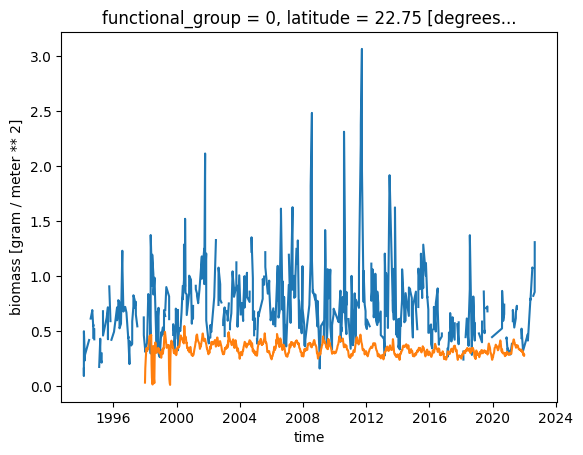

In [ ]:
obs_hot.observation.day.pint.quantify().pint.to("g/m2").plot()
biomass_print.sel(latitude=22.75, longitude=-158, functional_group=0).pint.quantify().pint.to("g/m2").plot()